# 特徴量エンジニアリング
- ベースラインに肉付けしていく形で行う
- 一つの特徴量を作成・補完したらその都度精度確認
  - もし、精度が下がったら没
  - 上がったら採用

### 欠損値の処理

- 適当に値をぶっ込むは絶対にしない
  - やってることデータの改変と同じ

#### 基本的に

- 数値データ
  - 平均 or0
- カテゴリ変数
  - 空白埋め or 最頻値置換


### 外れ値の検出・補正
- 外れ値は値を見ただけで瞬時に判断できないため、欠損値よりも把握するのが難しい

#### 補正方法
- レコードごと除外する
- 欠損値に変換する
- ヒアリングして外れ値を正しい値に変換する
- 他のデータから推定して補正する
- 何もしない

迷ったら何もしないのが適切

In [1]:
import pandas as pd
import pipeline
import importlib
import numpy as np

importlib.reload(pipeline)
from pipeline.baseline import Baseline

### 要約統計量の表示

In [2]:
df_titanic_train = pd.read_csv("../../data/train.csv")

df_titanic_train.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [3]:
print(df_titanic_train.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


## Ageをコネコネする


<Axes: ylabel='Frequency'>

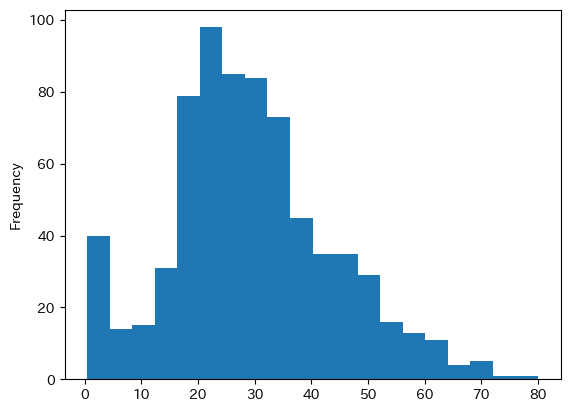

In [4]:
# Ageをプロット
df_titanic_train["Age"].plot(kind="hist", bins=20)

### Ageの欠損値を離散化＆平均埋めが精度向上につながるか検証

#### Ageの欠損値を平均値で埋める

In [5]:
df_titanic_train_age_mean = df_titanic_train.copy()
df_titanic_train_age_mean["Age"] = df_titanic_train_age_mean["Age"].fillna(
    df_titanic_train_age_mean["Age"].mean()
)

print(df_titanic_train_age_mean.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


#### Ageを離散化する

<Axes: xlabel='Age_bin'>

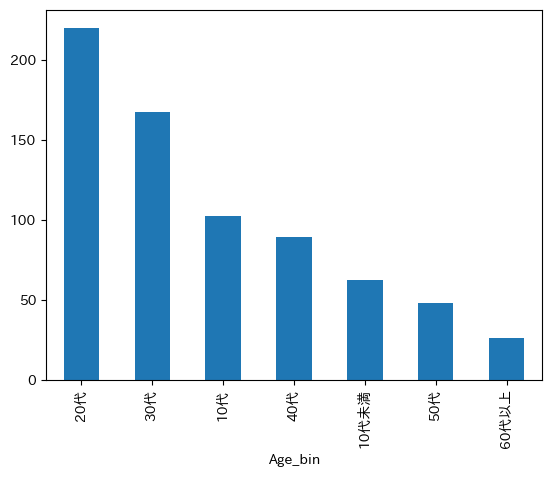

In [6]:
df_titanic_train_discretization = df_titanic_train.copy()
# 離散化
df_titanic_train_discretization["Age_bin"] = pd.cut(
    df_titanic_train_discretization["Age"],
    bins=[0, 10, 20, 30, 40, 50, 60, 100],
    labels=["10代未満", "10代", "20代", "30代", "40代", "50代", "60代以上"],
    right=False,
    duplicates="raise",
    include_lowest=True,
)

# 離散化結果をプロット
df_titanic_train_discretization["Age_bin"].value_counts().plot(kind="bar")

#### モデル精度検証

何もしない 0.6700834850291884
平均埋め 0.6700834850291884
平均埋め離散化 0.6835603540267403


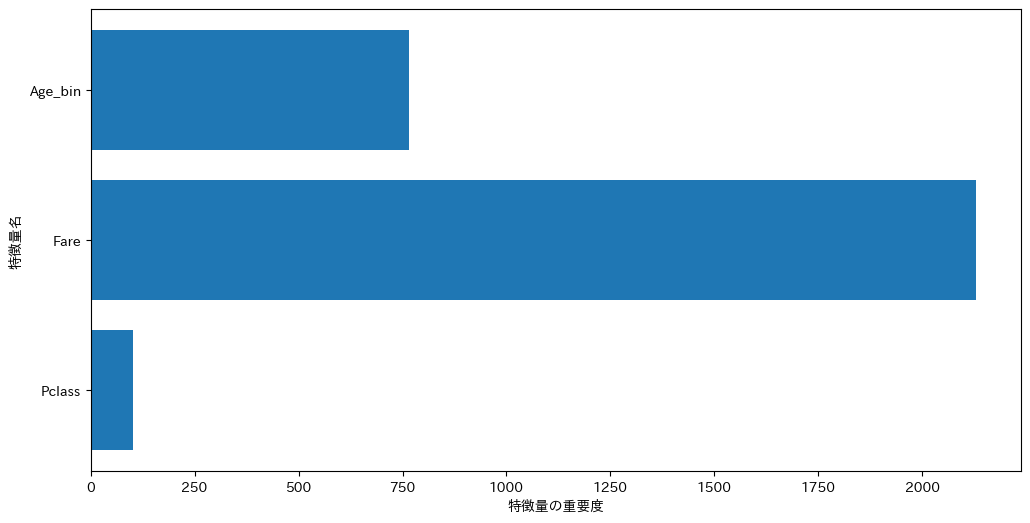

In [7]:
X, y, id = (
    df_titanic_train[["Pclass", "Fare", "Age"]],
    df_titanic_train["Survived"],
    df_titanic_train["PassengerId"],
)
X_ave, y_ave, id_ave = (
    df_titanic_train_age_mean[["Pclass", "Fare", "Age"]],
    df_titanic_train_age_mean["Survived"],
    df_titanic_train_age_mean["PassengerId"],
)
X_disc, y_disc, id_disc = (
    df_titanic_train_discretization[["Pclass", "Fare", "Age_bin"]],
    df_titanic_train_discretization["Survived"],
    df_titanic_train_discretization["PassengerId"],
)

bl = Baseline(input_X=X, input_y=y, input_id=id)
bl_ave = Baseline(input_X=X_ave, input_y=y_ave, input_id=id_ave)
bl_disc = Baseline(input_X=X_disc, input_y=y_disc, input_id=id_disc)

imps, score = bl.create_model()
imps_ave, score_ave = bl_ave.create_model()
imps_disc, score_disc = bl_disc.create_model()

print("何もしない", score)
print("平均埋め", score_ave)
print("平均埋め離散化", score_disc)

bl_disc.plot_feature_importance(imps_disc)

## Ageをランダムフォレストを元にして欠損値処理をする

In [ ]:
# ------------ Age ------------
# Age を Pclass, Sex, Parch, SibSp からランダムフォレストで推定
from sklearn.ensemble import RandomForestRegressor

# 推定に使用する項目を指定
age_df = df_titanic_train[["Age", "Pclass", "Sex", "Parch", "SibSp"]]

# ラベル特徴量をワンホットエンコーディング
age_df = pd.get_dummies(age_df)

# 学習データとテストデータに分離し、numpyに変換
known_age = age_df[age_df.Age.notnull()].values
unknown_age = age_df[age_df.Age.isnull()].values

# 学習データをX, yに分離
X = known_age[:, 1:]
y = known_age[:, 0]

# ランダムフォレストで推定モデルを構築
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)

# 推定モデルを使って、テストデータのAgeを予測し、補完
predictedAges = rfr.predict(unknown_age[:, 1::])
df.loc[(df.Age.isnull()), "Age"] = predictedAges

# 年齢別生存曲線と死亡曲線
facet = sns.FacetGrid(df[0:890], hue="Survived", aspect=2)
facet.map(sns.kdeplot, "Age", shade=True)
facet.set(xlim=(0, df.loc[0:890, "Age"].max()))
facet.add_legend()
plt.show()